This notebook is part of the Kaggle Home Credit Default Risk competition. The goal of this competition is to predict the probability of default on a loan for a Home Credit Bank client. The evaluation metric is ROC-AUC. In this second notebook we leverage the preprocessed datasets to build, tune, and evaluate predictive models, aiming to accurately identify clients at risk of default.

# **Base imports**

In [ ]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import __version__ as sklearn_version
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
print(f'pandas=={pd.__version__}')
print(f'numpy=={np.__version__}')
print(f'sklearn=={sklearn_version}')
print(f'matplotlib=={matplotlib.__version__}')
print(f'seaborn=={sns.__version__}')

pandas==2.2.2
numpy==2.0.2
sklearn==1.6.1
matplotlib==3.10.0
seaborn==0.13.2


# **Loading the processed datasets**

In [ ]:
df_full_train = pd.read_parquet('processed-data/homecredit_df_train.parquet')
df_test = pd.read_parquet('processed-data/homecredit_df_test.parquet')
test_ids = pd.read_parquet('processed-data/homecredit_test_ids.parquet')

# **Analyzing feature importance and correlations**

We start by examining the overall default rate in the training dataset, which is about 8%. This provides a baseline to compare different groups and features against.

In [ ]:
global_default_rate = df_full_train.target.mean()
global_default_rate

np.float64(0.08072881945686496)

In [ ]:
from IPython.display import display

In [ ]:
categorical_col = list(df_full_train.dtypes[df_full_train.dtypes == 'object'].index)
numerical_col = list(df_full_train.dtypes[df_full_train.dtypes != 'object'].index)
numerical_col.remove('target')

We explored how default rates vary across categories of nominal features. Key observations include:

- Borrowers with only lower secondary education show higher default risk.

- Renters or those living with parents tend to default more.

- People working in industrial sectors, restaurants, and transport also have elevated default rates.

We calculated a “risk multiplier” relative to the global default rate to quantify which groups are riskier than average.

In [ ]:
for col in categorical_col:
  print(col)
  df_group = df_full_train.groupby(col).target.agg(['mean', 'count'])
  df_group['diff'] = df_group['mean'] - global_default_rate
  df_group['risk'] = df_group['mean'] / global_default_rate
  display(df_group)
  print()
  print()

name_contract_type


,mean,count,diff,risk
name_contract_type,,,,
cash_loans,0.083459,278232,0.002730,1.033821
revolving_loans,0.054783,29279,-0.025946,0.678609




code_gender


,mean,count,diff,risk
code_gender,,,,
f,0.069993,202448,-0.010736,0.867017
m,0.101419,105059,0.020690,1.256295
xna,0.000000,4,-0.080729,0.000000




flag_own_car


,mean,count,diff,risk
flag_own_car,,,,
n,0.085002,202924,0.004273,1.052936
y,0.072437,104587,-0.008292,0.897292




flag_own_realty


,mean,count,diff,risk
flag_own_realty,,,,
n,0.083249,94199,0.002520,1.031221
y,0.079616,213312,-0.001113,0.986213




name_type_suite


,mean,count,diff,risk
name_type_suite,,,,
children,0.073768,3267,-0.006961,0.913775
family,0.074946,40149,-0.005783,0.928365
group_of_people,0.084871,271,0.004142,1.051308
other_a,0.087760,866,0.007031,1.087094
other_b,0.098305,1770,0.017576,1.217720
"spouse,_partner",0.078716,11370,-0.002013,0.975066
unaccompanied,0.081687,249818,0.000959,1.011875




name_income_type


,mean,count,diff,risk
name_income_type,,,,
businessman,0.000000,10,-0.080729,0.000000
commercial_associate,0.074843,71617,-0.005886,0.927086
maternity_leave,0.400000,5,0.319271,4.954860
pensioner,0.053864,55362,-0.026865,0.667217
state_servant,0.057550,21703,-0.023179,0.712876
student,0.000000,18,-0.080729,0.000000
unemployed,0.363636,22,0.282908,4.504418
working,0.095885,158774,0.015156,1.187738




name_education_type


,mean,count,diff,risk
name_education_type,,,,
academic_degree,0.018293,164,-0.062436,0.226594
higher_education,0.053551,74863,-0.027178,0.663346
incomplete_higher,0.084850,10277,0.004121,1.051046
lower_secondary,0.109277,3816,0.028548,1.353627
secondary_/_secondary_special,0.089399,218391,0.008670,1.107402




name_family_status


,mean,count,diff,risk
name_family_status,,,,
civil_marriage,0.099446,29775,0.018717,1.231851
married,0.075599,196432,-0.005130,0.936452
separated,0.081942,19770,0.001214,1.015032
single_/_not_married,0.098077,45444,0.017348,1.214891
unknown,0.000000,2,-0.080729,0.000000
widow,0.058242,16088,-0.022487,0.721454




name_housing_type


,mean,count,diff,risk
name_housing_type,,,,
co-op_apartment,0.079323,1122,-0.001406,0.982581
house_/_apartment,0.077957,272868,-0.002772,0.965666
municipal_apartment,0.085397,11183,0.004669,1.057831
office_apartment,0.065724,2617,-0.015005,0.814134
rented_apartment,0.123131,4881,0.042402,1.525236
with_parents,0.116981,14840,0.036252,1.449063




weekday_appr_process_start


,mean,count,diff,risk
weekday_appr_process_start,,,,
friday,0.081469,50338,0.000740,1.009172
monday,0.077572,50714,-0.003157,0.960899
saturday,0.078873,33852,-0.001856,0.977008
sunday,0.079291,16181,-0.001438,0.982184
thursday,0.081003,50591,0.000274,1.003391
tuesday,0.083505,53901,0.002776,1.034388
wednesday,0.081604,51934,0.000875,1.010836




organization_type


,mean,count,diff,risk
organization_type,,,,
advertising,0.081585,429,0.000856,1.010607
agriculture,0.104727,2454,0.023998,1.297269
bank,0.051855,2507,-0.028874,0.642333
business_entity_type_1,0.081384,5984,0.000655,1.008112
business_entity_type_2,0.085284,10553,0.004555,1.056423
business_entity_type_3,0.092996,67992,0.012267,1.151958
cleaning,0.111538,260,0.030810,1.381644
construction,0.116798,6721,0.036069,1.446796
culture,0.055409,379,-0.025320,0.686359


In [ ]:
from sklearn.metrics import mutual_info_score

def mutual_info_default_score(series):
  return mutual_info_score(series, df_full_train.target)

Using mutual information scores, we quantified how much information each categorical feature provides about the target (default/no default).

The most informative features are organization type, income type, and education type.

Other categorical features carry less predictive signal individually, but may still be useful in combination with other features.

In [ ]:
mi = df_full_train[categorical_col].apply(mutual_info_default_score)
mi = mi.sort_values(ascending = False)
mi

,0
organization_type,0.002668
name_income_type,0.002114
name_education_type,0.001796
code_gender,0.001452
name_family_status,0.000809
name_housing_type,0.000613
name_contract_type,0.000528
flag_own_car,0.000243
name_type_suite,0.000052
weekday_appr_process_start,0.000025


We assessed numerical features using Spearman’s correlation with the target to capture monotonic relationships.

Features with the highest positive correlation: days_birth, closed_days_credit_mean, closed_days_credit_min. These indicate that age and historical credit behavior have some predictive power.

Features with the highest negative correlation: ext_source_2 and ext_source_3. These external scoring features are inversely related to default risk.

**Important Note:** All correlation coefficients are relatively low, with the highest absolute values around 0.14 and most between 0.01–0.04. This is typical in credit scoring, where individual variables usually provide only weak signals. Strong predictions generally come from aggregating multiple weak features through a robust model.

In [ ]:
corr = df_full_train[numerical_col].corrwith(df_full_train.target, method='spearman').sort_values(ascending=False)
corr

,0
days_birth,0.078328
closed_days_credit_mean,0.072187
closed_days_credit_min,0.071003
closed_days_credit_update_mean,0.065676
closed_days_credit_enddate_min,0.064090
refused_cnt_payment_sum,0.061881
region_rating_client_w_city,0.060936
inst_dpd_mean,0.060658
region_rating_client,0.058909
refused_cnt_payment_mean,0.058582


Given the weak linear relationships observed:

- Linear models like logistic regression are unlikely to perform well because individual features do not have strong predictive power.

- Tree-based models such as Decision Trees and Gradient Boosted Trees are better suited for this dataset because they can capture non-linear interactions between multiple weak signals.

- Tree models are also robust to different feature scales, missing values, and can handle categorical variables effectively after encoding.

In short, the dataset characteristics strongly suggest that tree-based classifiers (DTC, XGBoost, etc.) will outperform simple linear models for predicting credit default.

# **Target encoding categorical features**

Before training our models, all categorical variables must be converted into numeric format. One effective approach is target encoding, which replaces each category with a statistic derived from the target variable — in our case, the mean default rate for that category. This allows the model to leverage the relationship between the category and the target.

In [ ]:
from sklearn.preprocessing import TargetEncoder

encoder = TargetEncoder(
    target_type='continuous',
    smooth='auto')


In [ ]:
train_encoded_cats = encoder.fit_transform(
    df_full_train[categorical_col],
    df_full_train['target']
)

In [ ]:
df_full_train_encoded = pd.DataFrame(train_encoded_cats)

new_column_names = []
for col in categorical_col:
    new_column_names.append(f'{col}_encoded')

df_full_train_encoded.columns = new_column_names

# Adding numerical columns
df_full_train_encoded[numerical_col] = df_full_train[numerical_col]

# Adding target
df_full_train_encoded['target'] = df_full_train['target']

df_full_train_encoded = df_full_train_encoded.copy()

/tmp/ipython-input-1021878596.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_full_train_encoded[numerical_col] = df_full_train[numerical_col]
/tmp/ipython-input-1021878596.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_full_train_encoded[numerical_col] = df_full_train[numerical_col]
/tmp/ipython-input-1021878596.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.co

In [ ]:
df_full_train_encoded.head()

,name_contract_type_encoded,code_gender_encoded,flag_own_car_encoded,flag_own_realty_encoded,name_type_suite_encoded,name_income_type_encoded,name_education_type_encoded,name_family_status_encoded,name_housing_type_encoded,weekday_appr_process_start_encoded,organization_type_encoded,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,cnt_fam_members,region_rating_client,region_rating_client_w_city,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,ext_source_2,ext_source_3,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,days_employed_coef,income_credit_coef,income_per_person,annnuity_income_ratio,payment_rate,active_days_credit_min,active_days_credit_max,active_days_credit_mean,active_days_credit_enddate_min,active_days_credit_enddate_max,active_days_credit_enddate_mean,active_days_credit_update_mean,active_credit_day_overdue_max,active_credit_day_overdue_mean,active_amt_credit_max_overdue_mean,active_amt_credit_sum_max,active_amt_credit_sum_mean,active_amt_credit_sum_sum,active_amt_credit_sum_debt_max,active_amt_credit_sum_debt_mean,active_amt_credit_sum_debt_sum,active_amt_credit_sum_overdue_mean,active_amt_credit_sum_limit_mean,active_amt_credit_sum_limit_sum,active_cnt_credit_prolong_sum,closed_days_credit_min,closed_days_credit_max,closed_days_credit_mean,closed_days_credit_enddate_min,closed_days_credit_enddate_max,closed_days_credit_enddate_mean,closed_days_credit_update_mean,closed_credit_day_overdue_max,closed_credit_day_overdue_mean,closed_amt_credit_max_overdue_mean,closed_amt_credit_sum_max,closed_amt_credit_sum_mean,closed_amt_credit_sum_sum,closed_amt_credit_sum_debt_max,closed_amt_credit_sum_debt_mean,closed_amt_credit_sum_debt_sum,closed_amt_credit_sum_overdue_mean,closed_amt_credit_sum_limit_mean,closed_amt_credit_sum_limit_sum,closed_cnt_credit_prolong_sum,approved_amt_annuity_min,approved_amt_annuity_max,approved_amt_annuity_mean,approved_amt_application_min,approved_amt_application_max,approved_amt_application_mean,approved_amt_credit_min,approved_amt_credit_max,approved_amt_credit_mean,approved_amt_down_payment_min,approved_amt_down_payment_max,approved_amt_down_payment_mean,approved_amt_goods_price_min,approved_amt_goods_price_max,approved_amt_goods_price_mean,approved_days_decision_min,approved_days_decision_max,approved_days_decision_mean,approved_cnt_payment_mean,approved_cnt_payment_sum,refused_amt_annuity_min,refused_amt_annuity_max,refused_amt_annuity_mean,refused_amt_application_min,refused_amt_application_max,refused_amt_application_mean,refused_amt_credit_min,refused_amt_credit_max,refused_amt_credit_mean,refused_amt_down_payment_min,refused_amt_down_payment_max,refused_amt_down_payment_mean,refused_amt_goods_price_min,refused_amt_goods_price_max,refused_amt_goods_price_mean,refused_days_decision_min,refused_days_decision_max,refused_days_decision_mean,refused_cnt_payment_mean,refused_cnt_payment_sum,inst_nunique_inst_ver,inst_dpd_max,inst_dpd_mean,inst_dpd_sum,target
0,0.083406,0.101483,0.084667,0.079472,0.081443,0.095618,0.089178,0.098425,0.077829,0.081333,0.093560,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,-2120,1

In [ ]:
# Using the same encoder that was fitted on training data

test_encoded_cats = encoder.transform(df_test[categorical_col])

# Creating the test DataFrame the same way
df_test_encoded = pd.DataFrame(test_encoded_cats)
df_test_encoded.columns = new_column_names  # Using the same column names

# Adding numerical columns
df_test_encoded[numerical_col] = df_test[numerical_col]

/tmp/ipython-input-3567093945.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test_encoded[numerical_col] = df_test[numerical_col]
/tmp/ipython-input-3567093945.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test_encoded[numerical_col] = df_test[numerical_col]
/tmp/ipython-input-3567093945.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

In [ ]:
df_test_encoded.head()

,name_contract_type_encoded,code_gender_encoded,flag_own_car_encoded,flag_own_realty_encoded,name_type_suite_encoded,name_income_type_encoded,name_education_type_encoded,name_family_status_encoded,name_housing_type_encoded,weekday_appr_process_start_encoded,organization_type_encoded,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,cnt_fam_members,region_rating_client,region_rating_client_w_city,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,ext_source_2,ext_source_3,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,days_employed_coef,income_credit_coef,income_per_person,annnuity_income_ratio,payment_rate,active_days_credit_min,active_days_credit_max,active_days_credit_mean,active_days_credit_enddate_min,active_days_credit_enddate_max,active_days_credit_enddate_mean,active_days_credit_update_mean,active_credit_day_overdue_max,active_credit_day_overdue_mean,active_amt_credit_max_overdue_mean,active_amt_credit_sum_max,active_amt_credit_sum_mean,active_amt_credit_sum_sum,active_amt_credit_sum_debt_max,active_amt_credit_sum_debt_mean,active_amt_credit_sum_debt_sum,active_amt_credit_sum_overdue_mean,active_amt_credit_sum_limit_mean,active_amt_credit_sum_limit_sum,active_cnt_credit_prolong_sum,closed_days_credit_min,closed_days_credit_max,closed_days_credit_mean,closed_days_credit_enddate_min,closed_days_credit_enddate_max,closed_days_credit_enddate_mean,closed_days_credit_update_mean,closed_credit_day_overdue_max,closed_credit_day_overdue_mean,closed_amt_credit_max_overdue_mean,closed_amt_credit_sum_max,closed_amt_credit_sum_mean,closed_amt_credit_sum_sum,closed_amt_credit_sum_debt_max,closed_amt_credit_sum_debt_mean,closed_amt_credit_sum_debt_sum,closed_amt_credit_sum_overdue_mean,closed_amt_credit_sum_limit_mean,closed_amt_credit_sum_limit_sum,closed_cnt_credit_prolong_sum,approved_amt_annuity_min,approved_amt_annuity_max,approved_amt_annuity_mean,approved_amt_application_min,approved_amt_application_max,approved_amt_application_mean,approved_amt_credit_min,approved_amt_credit_max,approved_amt_credit_mean,approved_amt_down_payment_min,approved_amt_down_payment_max,approved_amt_down_payment_mean,approved_amt_goods_price_min,approved_amt_goods_price_max,approved_amt_goods_price_mean,approved_days_decision_min,approved_days_decision_max,approved_days_decision_mean,approved_cnt_payment_mean,approved_cnt_payment_sum,refused_amt_annuity_min,refused_amt_annuity_max,refused_amt_annuity_mean,refused_amt_application_min,refused_amt_application_max,refused_amt_application_mean,refused_amt_credit_min,refused_amt_credit_max,refused_amt_credit_mean,refused_amt_down_payment_min,refused_amt_down_payment_max,refused_amt_down_payment_mean,refused_amt_goods_price_min,refused_amt_goods_price_max,refused_amt_goods_price_mean,refused_days_decision_min,refused_days_decision_max,refused_days_decision_mean,refused_cnt_payment_mean,refused_cnt_payment_sum,inst_nunique_inst_ver,inst_dpd_max,inst_dpd_mean,inst_dpd_sum
0,0.083459,0.069993,0.085002,0.079616,0.081687,0.095885,0.053551,0.075599,0.077957,0.083505,0.070350,0,135000.0,568800.0,20560.5,450000.0,0.018850,-19241,-2329,-5170.0,-812,1,1,0,1

# **Removing identical features**

Before modeling, it’s important to check for highly correlated features (multicollinearity). Features that are nearly identical (correlation ≥ 0.99) do not provide additional predictive value and can increase model complexity unnecessarily.

Identifying Highly Correlated Features

- We computed the Spearman correlation matrix of all independent variables.

- Pairs of features with absolute correlation ≥ 0.99 were flagged for review.

- For each highly correlated pair, we compared their correlation with the target variable.

From each correlated pair, we removed the feature with lower correlation with the target, keeping the one that retains the stronger predictive signal. Key decisions included:

- For active and closed credit features: keep the maximum or sum values over the mean.

- For previous applications: keep application amounts rather than goods price (to avoid redundancy).

- For refused applications: keep maximum/minimum or sum-based aggregates rather than mean values.

- Observation periods and social circle counts: keep features representing longer periods or sums.

This approach preserves information while removing redundancy.

In [ ]:
corr_matrix = df_full_train_encoded.corr(method = 'spearman')

pairs = []
features = corr_matrix.columns

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr = corr_matrix.iloc[i, j]
        if abs(corr) > 0.99:
            pairs.append({
                'feature1': corr_matrix.columns[i],
                'feature2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j],
                'target_corr1': corr_matrix.loc['target', corr_matrix.columns[i]],
                'target_corr2': corr_matrix.loc['target', corr_matrix.columns[j]]
            })


multicoll_df = pd.DataFrame(pairs)
multicoll_df

,feature1,feature2,correlation,target_corr1,target_corr2
0,obs_30_cnt_social_circle,obs_60_cnt_social_circle,0.997338,0.009837,0.009684
1,active_credit_day_overdue_max,active_credit_day_overdue_mean,0.999997,0.030352,0.030336
2,active_amt_credit_sum_debt_max,active_amt_credit_sum_debt_sum,0.992909,0.023114,0.026910
3,active_amt_credit_sum_limit_mean,active_amt_credit_sum_limit_sum,0.999529,0.024312,0.024808
4,closed_credit_day_overdue_max,closed_credit_day_overdue_mean,1.000000,0.000927,0.000927
5,closed_amt_credit_sum_debt_mean,closed_amt_credit_sum_debt_sum,0.999990,0.005027,0.005015
6,closed_amt_credit_sum_limit_mean,closed_amt_credit_sum_limit_sum,0.999988,-0.001603,-0.001616
7,approved_amt_application_min,approved_amt_goods_price_min,1.000000,-0.006730,-0.006730
8,approved_amt_application_max,approved_amt_goods_price_max,1.000000,-0.028263,-0.028263
9,approved_amt_application_mean,approved_amt_goods_price_mean,1.000000,-0.025961,-0.025961


In [ ]:
cols_to_drop = [
    # Active credits - keeping max over mean
    'active_credit_day_overdue_mean',
    'active_amt_credit_sum_debt_max',  # Keeping sum instead
    'active_amt_credit_sum_limit_mean',  # Keeping sum instead

    # Closed credits - keeping max over mean
    'closed_credit_day_overdue_mean',
    'closed_amt_credit_sum_debt_mean',  # Keeping sum instead
    'closed_amt_credit_sum_limit_mean',  # Keeping sum instead

    # Approved applications - removing goods_price (keeping application amounts)
    'approved_amt_goods_price_min',
    'approved_amt_goods_price_max',
    'approved_amt_goods_price_mean',

    # Refused applications - keeping max over mean, removing goods_price duplicates
    'refused_amt_annuity_mean',
    'refused_amt_application_mean',
    'refused_amt_credit_mean',
    'refused_amt_down_payment_mean',
    'refused_amt_goods_price_min',
    'refused_amt_goods_price_max',
    'refused_amt_goods_price_mean',
    'refused_days_decision_mean',  # Keeping min/max instead

    # Observation periods - keeping longer window
    'obs_30_cnt_social_circle',

    # Payment counts - keeping sum over mean
    'refused_cnt_payment_mean'
]



df_full_train_encoded = df_full_train_encoded.drop(columns=cols_to_drop)
df_test_encoded = df_test_encoded.drop(columns=cols_to_drop)

In [ ]:
corr_matrix = df_full_train_encoded.corr(method = 'spearman')

pairs = []
features = corr_matrix.columns

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr = corr_matrix.iloc[i, j]
        if abs(corr) > 0.99:
            pairs.append({
                'feature1': corr_matrix.columns[i],
                'feature2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j],
                'target_corr1': corr_matrix.loc['target', corr_matrix.columns[i]],
                'target_corr2': corr_matrix.loc['target', corr_matrix.columns[j]]
            })


multicoll_df = pd.DataFrame(pairs)
multicoll_df

""


# **Splitting full train into train and validation sets**

Before training any models, we need to evaluate their performance on unseen data. To do this properly, we split the full training dataset into:

- Training set — used for fitting the model

- Validation set — used for tuning hyperparameters and checking generalization

A validation set allows us to:

- Assess how well the model generalizes to unseen examples

- Compare different models or hyperparameters in a fair way

- Detect overfitting early (when a model learns the training data too well but performs poorly on new data)

We use train_test_split from scikit-learn with the following settings:

- test_size=0.2 — 20% of the data is allocated to the validation set

- `stratify=df_full_train_encoded['target']` — keeps the default rate (positive class ratio) identical in both train and validation sets

These datasets are now ready for building and evaluating tree-based classifiers in the next steps.

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(
    df_full_train_encoded,
    test_size=0.2,
    random_state=42,
    stratify=df_full_train_encoded['target']
)

In [ ]:
df_train.shape, df_val.shape

((246008, 141), (61503, 141))

# **Decision tree classifier model**

The goal of this stage is to build a compact, interpretable model that captures the most predictive patterns in the data while remaining efficient and deployable as a web service. By limiting the model to the strongest features and using a decision tree, we ensure the model is understandable, lightweight, and easy to maintain, without sacrificing predictive signal.

To identify the most important features, we first train a Decision Tree Classifier (DTC) on the full engineered dataset (≈140 features after encoding). At this stage, the goal is feature selection, not maximum performance. The Home Credit data contains many weak predictors, so the feature-selection tree is intentionally heavily regularized to extract stable, consistent patterns.

The selector tree uses the following parameters:

- max_depth = 12 — deep enough to capture meaningful non-linear relationships but not so deep that it memorizes noise.

- min_samples_split = 500 and min_samples_leaf = 250 — very large values to allow splits only when supported by a strong, consistent signal.

- class_weight = 'balanced' — accounts for target imbalance so both classes influence feature importance.

This tree achieves a ROC AUC of 0.77 on training and 0.70 on validation, confirming it is expressive enough to detect useful predictors while remaining regularized.

Feature importances are then extracted and sorted, and the top 20 features are selected. Limiting the model to 20 features is intentional: a smaller set ensures fast, lightweight, and maintainable inference in a deployed environment.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
X_train = df_train.drop('target', axis = 1).values
X_val = df_val.drop('target', axis = 1).values

y_train = df_train['target'].values
y_val = df_val['target'].values

In [ ]:
dtc_selector = DecisionTreeClassifier(
    max_depth=12,
    min_samples_split=500,
    min_samples_leaf=250,
    random_state=42,
    class_weight='balanced'
)
dtc_selector.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=12,
                       min_samples_leaf=250, min_samples_split=500,
                       random_state=42)

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
y_pred_train = dtc_selector.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred_train)

np.float64(0.7777814213039929)

In [ ]:
y_pred_val = dtc_selector.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_val)

np.float64(0.7097589561541139)

In [ ]:
feature_names = df_train.drop('target', axis = 1).columns.to_list()

In [ ]:
importances = dtc_selector.feature_importances_

feature_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)


feature_imp_df.head(20)

,feature,importance
38,ext_source_3,0.312896
37,ext_source_2,0.251842
138,inst_dpd_mean,0.034050
10,organization_type_encoded,0.029728
118,approved_amt_down_payment_max,0.022565
73,payment_rate,0.021700
6,name_education_type_encoded,0.020697
17,days_birth,0.019579
1,code_gender_encoded,0.018073
120,approved_days_decision_min,0.015071


In [ ]:
selected_features = feature_imp_df.head(20)['feature'].tolist()

X_train_dtc = df_train[selected_features].values
X_val_dtc = df_val[selected_features].values

Using the 20 selected predictors, we explore how model depth affects validation AUC (depths 2–15) and perform a small grid search over:

- max_depth ∈ {6, 7, 8}

- min_samples_leaf ∈ {200, 300, 500, 700, 1000, 1500, 2000}

This helps identify which combinations generalize best.

The best-performing configuration is:

- max_depth = 8

- min_samples_leaf = 1000

This final tree achieves ROC AUC = 0.723 on the validation set, slightly higher than the selector tree. Importantly, the feature importance ranking closely matches the selector’s, confirming that the top variables are stable and that the selector tree successfully captured the core structure of the dataset.

In [ ]:
for md in range(2, 16):

  dtc = DecisionTreeClassifier(max_depth=md, random_state=42, class_weight='balanced')
  dtc.fit(X_train_dtc, y_train)

  y_pred_val = dtc.predict_proba(X_val_dtc)[:, 1]

  score = roc_auc_score(y_val, y_pred_val)

  print(md,'-----',score.round(4))


2 ----- 0.6601
3 ----- 0.6886
4 ----- 0.7059
5 ----- 0.7127
6 ----- 0.7152
7 ----- 0.7187
8 ----- 0.7132
9 ----- 0.7061
10 ----- 0.6975
11 ----- 0.6879
12 ----- 0.6713
13 ----- 0.6558
14 ----- 0.6455
15 ----- 0.6362


In [ ]:
scores = []

for md in [6, 7, 8]:
  for leaf in [200, 300, 500, 700, 1000, 1500, 2000]:
     dtc = DecisionTreeClassifier(max_depth=md, min_samples_leaf=leaf, random_state=42, class_weight='balanced')
     dtc.fit(X_train_dtc, y_train)

     y_pred_val = dtc.predict_proba(X_val_dtc)[:, 1]

     score = roc_auc_score(y_val, y_pred_val)

     scores.append((md, leaf, score))

In [ ]:
col = ['max_depth', 'min_samples_leaf', 'score']
df_scores = pd.DataFrame(scores, columns = col)
df_scores.sort_values(by = 'score', ascending = False).head()

,max_depth,min_samples_leaf,score
18,8,1000,0.722858
19,8,1500,0.722694
20,8,2000,0.721818
17,8,700,0.721329
11,7,1000,0.721301


In [ ]:
df_scores_pivot = df_scores.pivot(index = 'min_samples_leaf', columns = ['max_depth'], values = ['score'])
df_scores_pivot

score                    
max_depth                6         7         8
min_samples_leaf                              
200               0.715748  0.718907  0.717651
300               0.716031  0.719869  0.719748
500               0.716115  0.720908  0.720885
700               0.716691  0.721105  0.721329
1000              0.717050  0.721301  0.722858
1500              0.716510  0.720158  0.722694
2000              0.717064  0.720369  0.721818

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

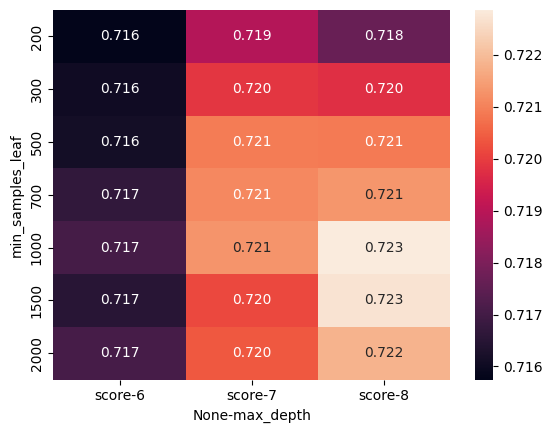

In [ ]:
sns.heatmap(df_scores_pivot, annot = True, fmt = '.3f')

The final tree assigns most of its predictive power to a small set of strong, stable features. As expected, the external scoring features dominate:

- `ext_source_3`

- `ext_source_2`

Together they account for more than 75% of the total importance, consistent with known domain behavior.

Other notable features include behavioural and demographic indicators:

- `inst_dpd_mean` — average days past due on installments

- `organization_type_encoded`, `name_education_type_encoded` — socioeconomic profile

- `payment_rate`, `approved_amt_down_payment_max` — borrower capacity and loan structure

- `days_birth`, `days_employed`, `days_employed_coef`, `income_credit_coef` — demographic stability and income-to-loan ratios

- credit history aggregates such as `closed_amt_credit_sum_sum`, `closed_days_credit_enddate_min`

Two features `days_last_phone_change` and `weekday_appr_process_start_encoded`	received zero importance, indicating they do not add additional predictive value beyond the other features.

In [ ]:
dtc = DecisionTreeClassifier(max_depth=8, min_samples_leaf=1000, random_state=42, class_weight='balanced')
dtc.fit(X_train_dtc, y_train)

importances = dtc.feature_importances_

feature_imp_df = pd.DataFrame({
    'feature': selected_features,
    'importance': importances
}).sort_values('importance', ascending=False)


feature_imp_df

,feature,importance
0,ext_source_3,0.432104
1,ext_source_2,0.339218
2,inst_dpd_mean,0.037054
3,organization_type_encoded,0.036563
6,name_education_type_encoded,0.027043
8,code_gender_encoded,0.024082
4,approved_amt_down_payment_max,0.018517
7,days_birth,0.017944
13,closed_amt_credit_sum_sum,0.011756
9,approved_days_decision_min,0.011269


Finally, the first three levels of the tree are visualized to illustrate key decision paths, showing how risk factors influence splits and how clients are segmented by risk.

Text(0.5, 1.0, 'Decision Tree Visualization (First Three levels)')

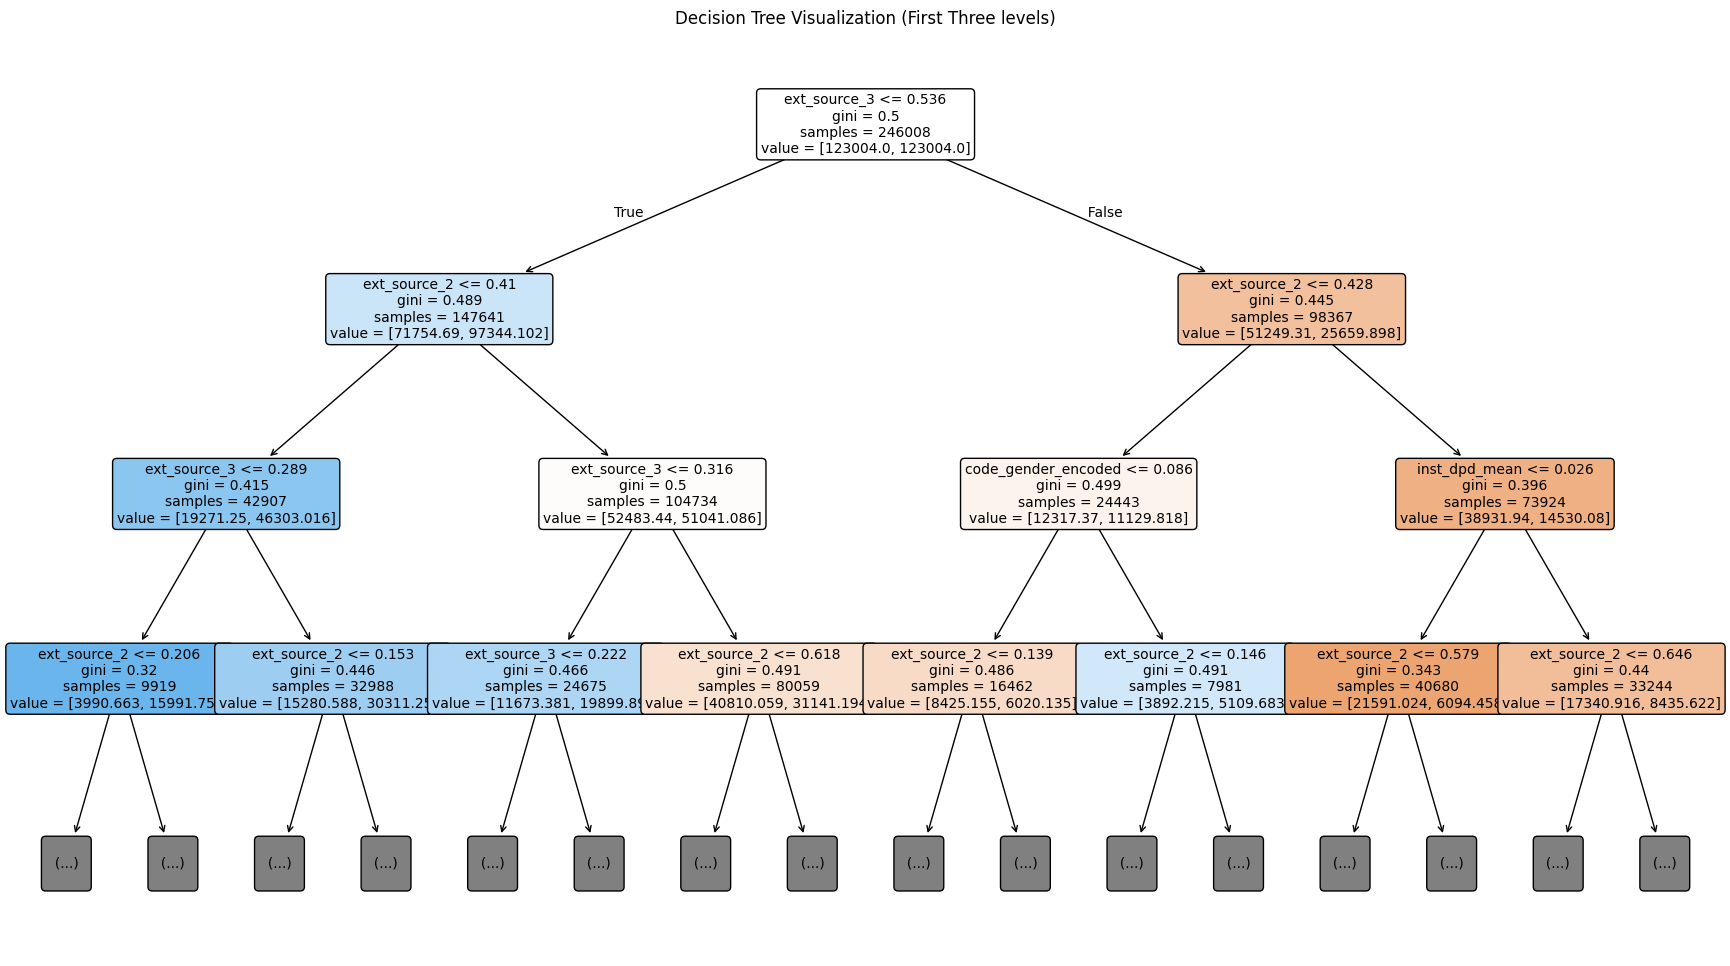

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(22, 12))
plot_tree(dtc,
          feature_names=selected_features,
          filled=True,
          rounded=True,
          fontsize=10,
           max_depth=3)  # Limit depth for readability

plt.title("Decision Tree Visualization (First Three levels)")

# **XGB Classifier model**

In this section we repeat the same methodology used for the Decision Tree Classifier, but with a more powerful gradient boosting model — XGBoost.
Our workflow follows two steps:

- Train a regularized XGBoost model to select the top 20 most important features.

- Train a tuned final XGBoost model using only those selected features.

This approach keeps the model compact, reduces redundancy in the feature space, and improves stability and interpretability during downstream deployment.

In [ ]:
import xgboost as xgb

In [ ]:
dtrain = xgb.DMatrix(X_train, label = y_train, feature_names= feature_names)
dval = xgb.DMatrix(X_val, label = y_val, feature_names= feature_names)

We begin by training an XGBoost model whose purpose is specifically to rank features, not to achieve perfect predictive performance.
The selector uses strong regularization to ensure that only robust and informative variables receive high importance.

Selector Model Parameters:

- High `min_child_weight` (50) prevents the model from learning weak splits.

- Subsampling and column sampling add randomness, improving importance stability.

- `Gamma` > 0 avoids tiny, noisy splits.

- Moderate depth captures meaningful nonlinearities.

Selector Performance:

- Train AUC ≈ 0.86

- Validation AUC ≈ 0.80

This stability indicates that the selector correctly captures essential structure without overfitting.

In [ ]:
xgb_selector_params = {
    'eta' : 0.1,
    'max_depth': 8,
    'min_child_weight' : 50,



    # adding these for better feature selection:
    'gamma': 0.05,                    # Minimum loss reduction for split
    'subsample': 0.8,                 # Random row sampling
    'colsample_bytree': 0.7,          # Random column sampling
    'lambda': 1.0,                    # L2 regularization



    'objective': 'binary:logistic',
    'nthread': -1,

    'seed': 42,
    'verbosity': 1,

    'eval_metric': 'auc',
    'tree_method': 'hist'

}

model = xgb.train(xgb_selector_params,
                  dtrain,
                  num_boost_round = 150)

model

In [ ]:
importances = model.get_score(importance_type='gain')

feature_imp_df = pd.DataFrame({
    'feature': list(importances.keys()),
    'importance': list(importances.values())
}).sort_values('importance', ascending=False)

feature_imp_df

,feature,importance
33,ext_source_3,90.261040
32,ext_source_2,77.754974
6,name_education_type_encoded,28.562147
69,active_amt_credit_sum_overdue_mean,25.187885
26,region_rating_client_w_city,24.023005
1,code_gender_encoded,23.896204
112,refused_cnt_payment_sum,21.783054
38,flag_document_3,20.558689
54,payment_rate,18.931652
34,def_30_cnt_social_circle,18.774176


In [ ]:
y_pred_train = model.predict(dtrain)
roc_auc_score(y_train, y_pred_train)

np.float64(0.8568363031688238)

In [ ]:
y_pred_val = model.predict(dval)
roc_auc_score(y_val, y_pred_val)

np.float64(0.7791162371629173)

The selector ranks features using gain, and the 20 highest-scoring features are extracted for further modeling.

After reducing the dataset to the selected 20 variables, we prepare smaller DMatrix objects and train a new model.

In [ ]:
selected_features = feature_imp_df.head(20)['feature'].tolist()

X_train_small = df_train[selected_features].values
X_val_small = df_val[selected_features].values


dtrain_small = xgb.DMatrix(X_train_small, label = y_train, feature_names= selected_features)
dval_small = xgb.DMatrix(X_val_small, label = y_val, feature_names= selected_features)

A quick default model is trained to inspect whether the reduced feature set holds enough predictive power.
Its performance confirms that the selected variables capture the essential signal.

In [ ]:
xgb_params = {
    'eta' : 0.3,
    'max_depth': 6,
    'min_child_weight' : 1,

    'objective': 'binary:logistic',
    'nthread': -1,

    'seed': 42,
    'verbosity': 1,

}

model = xgb.train(xgb_params, dtrain_small, num_boost_round = 100)

In [ ]:
y_pred_val = model.predict(dval_small)

In [ ]:
roc_auc_score(y_val, y_pred_val)

np.float64(0.7555004740281621)

**Hyperparameter Tuning**

We then tune the main XGBoost parameters manually:

- Learning rate (eta)

- Tree depth (max_depth)

- Minimum child weight (min_child_weight)

Each parameter is tested over multiple values, and AUC curves are plotted across all boosting rounds using a watchlist.

**Best Values Identified**

- **eta: 0.05**

- **max_depth: 4**

- **min_child_weight: 10**

- **num_boost_round: 850**

This configuration provides a strong balance between bias and variance, performs well on validation data, and remains stable over many boosting rounds.

In [ ]:
watchlist = [(dtrain_small, 'train'), (dval_small, 'val')]

In [ ]:
%%capture output

xgb_params = {
    'eta' : 0.3,
    'max_depth': 6,
    'min_child_weight' : 1,

    'objective': 'binary:logistic',
    'nthread': -1,

    'seed': 42,
    'verbosity': 1,

    'eval_metric': 'auc',
    'tree_method': 'hist'

}

model = xgb.train(xgb_params,dtrain_small,
                  num_boost_round = 200,
                  evals = watchlist,
                  verbose_eval = 5)

In [ ]:
print(output)

[0]	train-auc:0.72034	val-auc:0.71512
[5]	train-auc:0.75744	val-auc:0.74383
[10]	train-auc:0.77094	val-auc:0.75162
[15]	train-auc:0.77966	val-auc:0.75591
[20]	train-auc:0.78540	val-auc:0.75701
[25]	train-auc:0.78950	val-auc:0.75732
[30]	train-auc:0.79548	val-auc:0.75872
[35]	train-auc:0.79931	val-auc:0.75870
[40]	train-auc:0.80323	val-auc:0.75900
[45]	train-auc:0.80709	val-auc:0.75885
[50]	train-auc:0.81013	val-auc:0.75888
[55]	train-auc:0.81398	val-auc:0.75869
[60]	train-auc:0.81756	val-auc:0.75849
[65]	train-auc:0.81993	val-auc:0.75818
[70]	train-auc:0.82302	val-auc:0.75792
[75]	train-auc:0.82579	val-auc:0.75736
[80]	train-auc:0.82836	val-auc:0.75686
[85]	train-auc:0.83125	val-auc:0.75664
[90]	train-auc:0.83411	val-auc:0.75654
[95]	train-auc:0.83654	val-auc:0.75586
[100]	train-auc:0.83920	val-auc:0.75532
[105]	train-auc:0.84158	val-auc:0.75484
[110]	train-auc:0.84446	val-auc:0.75452
[115]	train-auc:0.84706	val-auc:0.75395
[120]	train-auc:0.84924	val-auc:0.75374
[125]	train-auc:0.8506

In [ ]:
def parse_xgb_output(output):
  results = []

  for line in output.stdout.strip().split('\n'):
    num_iter, train_auc, val_auc = line.split('\t')

    iter = int(num_iter.strip('[]'))
    train = float(train_auc.split(':')[1])
    val = float(val_auc.split(':')[1])

    results.append((iter, train, val))


  col = ['num_iter', 'train_auc', 'val_auc']
  df_results = pd.DataFrame(results, columns = col)
  return df_results

In [ ]:
df_scores = parse_xgb_output(output)
df_scores.sort_values('val_auc', ascending = False).head()

,num_iter,train_auc,val_auc
8,40,0.80323,0.75900
10,50,0.81013,0.75888
9,45,0.80709,0.75885
6,30,0.79548,0.75872
7,35,0.79931,0.75870


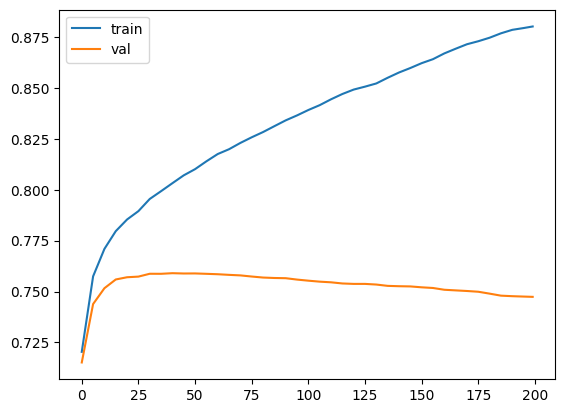

In [ ]:
plt.plot(df_scores.num_iter, df_scores.train_auc, label = 'train')
plt.plot(df_scores.num_iter, df_scores.val_auc, label = 'val')

plt.legend()

In [ ]:
# Tuning the 'eta' parameter first:
scores = {}

In [ ]:
%%capture output

xgb_params = {
    'eta' : 0.3,
    'max_depth': 6,
    'min_child_weight' : 1,

    'objective': 'binary:logistic',
    'nthread': -1,

    'seed': 42,
    'verbosity': 1,

    'eval_metric': 'auc',
    'tree_method': 'hist'

}

model = xgb.train(xgb_params,dtrain_small,
                  num_boost_round = 700,
                  evals = watchlist,
                  verbose_eval = 5)

In [ ]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.3'

In [ ]:
scores.keys()

dict_keys(['eta=0.05', 'eta=0.01', 'eta=0.1', 'eta=0.3'])

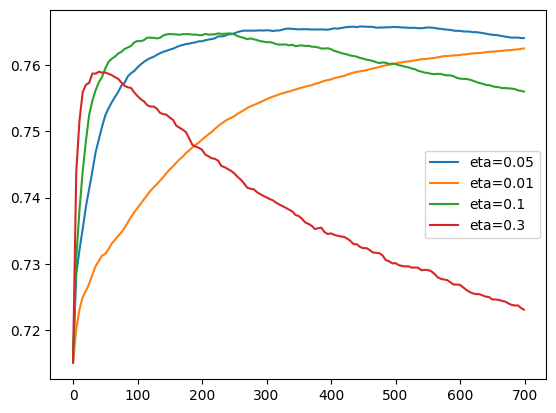

In [ ]:
for key, df in scores.items():
  plt.plot(df.num_iter, df.val_auc, label = key)
plt.legend()

In [ ]:
scores['eta=0.05'].sort_values('val_auc', ascending = False).head()

,num_iter,train_auc,val_auc
89,445,0.82869,0.76582
90,450,0.82937,0.76580
87,435,0.82762,0.76579
91,455,0.82972,0.76579
86,430,0.82721,0.76576


In [ ]:
# Now tuning the 'max_depth' parameter:
scores = {}

In [ ]:
%%capture output

xgb_params = {
    'eta' : 0.05,
    'max_depth': 8,
    'min_child_weight' : 1,

    'objective': 'binary:logistic',
    'nthread': -1,

    'seed': 42,
    'verbosity': 1,

    'eval_metric': 'auc',
    'tree_method': 'hist'

}

model = xgb.train(xgb_params,dtrain_small,
                  num_boost_round = 700,
                  evals = watchlist,
                  verbose_eval = 5)

In [ ]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=8'

In [ ]:
scores.keys()

dict_keys(['max_depth=4', 'max_depth=3', 'max_depth=6', 'max_depth=8'])

(0.74, 0.78)

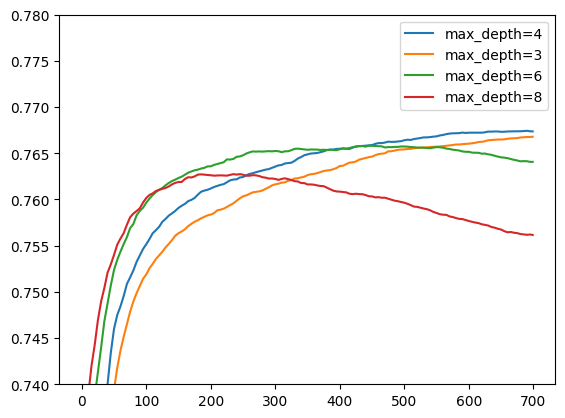

In [ ]:
for key, df in scores.items():
  plt.plot(df.num_iter, df.val_auc, label = key)
plt.legend()
plt.ylim(0.74, 0.78)

In [ ]:
scores['max_depth=4'].sort_values('val_auc', ascending = False).head()

,num_iter,train_auc,val_auc
138,690,0.79386,0.76743
137,685,0.79372,0.76740
134,670,0.79327,0.76738
135,675,0.79340,0.76738
139,695,0.79400,0.76738


In [ ]:
# Finally we tune the 'min_child_weight' parameter:
scores = {}

In [ ]:
%%capture output

xgb_params = {
    'eta' : 0.05,
    'max_depth': 4,
    'min_child_weight' : 100,

    'objective': 'binary:logistic',
    'nthread': -1,

    'seed': 42,
    'verbosity': 1,

    'eval_metric': 'auc',
    'tree_method': 'hist'

}

model = xgb.train(xgb_params,dtrain_small,
                  num_boost_round = 1000,
                  evals = watchlist,
                  verbose_eval = 5)

In [ ]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=100'

In [ ]:
scores.keys()

dict_keys(['min_child_weight=1', 'min_child_weight=10', 'min_child_weight=50', 'min_child_weight=100'])

(0.766, 0.769)

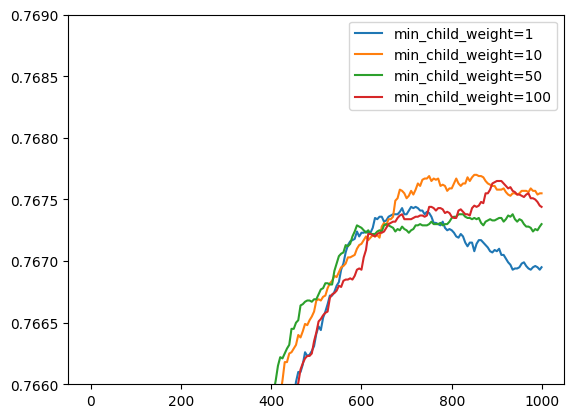

In [ ]:
for key, df in scores.items():
  plt.plot(df.num_iter, df.val_auc, label = key)
plt.legend()

plt.ylim(0.766, 0.769)

In [ ]:
scores['min_child_weight=10'].sort_values('val_auc', ascending = False).head()

,num_iter,train_auc,val_auc
170,850,0.79677,0.76770
171,855,0.79690,0.76770
172,860,0.79703,0.76769
150,750,0.79407,0.76769
173,865,0.79718,0.76769


Below is our final XGB Classifier model:

In [ ]:
xgb_params = {
    'eta' : 0.05,
    'max_depth': 4,
    'min_child_weight' : 10,

    'objective': 'binary:logistic',
    'nthread': -1,

    'seed': 42,
    'verbosity': 1,

    'eval_metric': 'auc',
    'tree_method': 'hist'

}

model = xgb.train(xgb_params,dtrain_small,
                  num_boost_round = 850)

model

After training the tuned model, we compute a new set of feature importances.
While the exact ordering shifts compared to the selector model (which is normal), the strongest predictors remain consistent:

- `ext_source_2`

- `ext_source_3`

- `flag_document_3`

- `payment_rate`

- `def_30_cnt_social_circle` / `def_60_cnt_social_circle`

- `code_gender_encoded`

- `inst_dpd_mean`

- `days_birth`

- `refused_cnt_payment_sum`

- `closed_amt_credit_sum_max`

This confirms that the selector successfully retained the core variables driving model performance.

In [ ]:
importances = model.get_score(importance_type='gain')

feature_imp_df = pd.DataFrame({
    'feature': list(importances.keys()),
    'importance': list(importances.values())
})

feature_imp_df_sorted = feature_imp_df.sort_values('importance', ascending=False)
feature_imp_df_sorted

,feature,importance
1,ext_source_2,58.647327
0,ext_source_3,56.672672
7,flag_document_3,31.271156
5,code_gender_encoded,23.026638
17,reg_city_not_live_city,18.567122
2,name_education_type_encoded,17.882509
9,def_30_cnt_social_circle,14.713807
6,refused_cnt_payment_sum,14.455009
8,payment_rate,14.257714
4,region_rating_client_w_city,13.782203


# **Training the final model on all data and submitting predictions**

Once the tuning process is complete and the optimal hyperparameters are identified, we retrain the final XGBoost model using all available training data and the 20 selected features. This ensures the model can learn from the maximum amount of information before generating predictions for the Kaggle test set.

To prepare the data, we extract the final feature list from the sorted importance DataFrame:

In [ ]:
cols = list(feature_imp_df_sorted.feature.values)

In [ ]:
X_train = df_full_train_encoded[cols].values
y_train = df_full_train_encoded['target'].values

In [ ]:
X_test = df_test_encoded[cols].values

We then wrap the data using XGBoost's optimized DMatrix structure:

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train,
                         feature_names = cols)

dtest = xgb.DMatrix(X_test, feature_names = cols)

We now train the model using the hyperparameters selected earlier:

In [ ]:
xgb_params = {
    'eta' : 0.05,
    'max_depth': 4,
    'min_child_weight' : 10,

    'objective': 'binary:logistic',
    'nthread': -1,

    'seed': 42,
    'verbosity': 1,
}

model = xgb.train(xgb_params,dtrain,
                  num_boost_round = 850)

model

In [ ]:
y_pred = model.predict(dtest)

In [ ]:
y_pred[:20]

array([0.03677442, 0.16238691, 0.03485015, 0.04057144, 0.13104752,
       0.03404691, 0.01471766, 0.05149345, 0.01699213, 0.08720896,
       0.08380118, 0.13963535, 0.14494354, 0.06813811, 0.05650484,
       0.13227053, 0.06177838, 0.03758575, 0.08363155, 0.0225077 ],
      dtype=float32)

In [ ]:
submission_df = pd.DataFrame({
    'SK_ID_CURR': test_ids.values.flatten(),
    'TARGET': y_pred
})

In [ ]:
submission_df.head()

,SK_ID_CURR,TARGET
0,100001,0.036774
1,100005,0.162387
2,100013,0.034850
3,100028,0.040571
4,100038,0.131048


The submitted model achieves a 0.756 AUC on the private Kaggle leaderboard — a competitive score for this dataset, especially given the intentionally compact 20-feature specification optimized for real-world deployment.